In [1]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from skvideo.io import FFmpegWriter 

img = cv2.imread('Frames/frame76.jpg')

### Binary Threshold

In [2]:
retval, threshold = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)

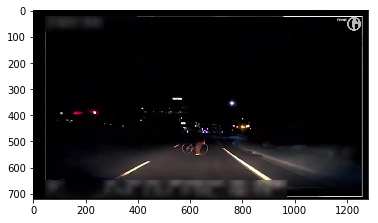

In [3]:
plt.imshow(img)

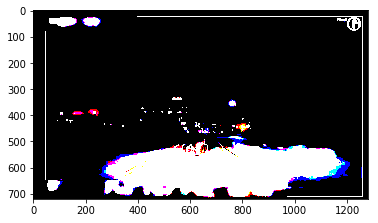

In [5]:
plt.imshow(threshold)

### Adaptive Thresholding

In [6]:
grayscaled = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
retval, threshold = cv2.threshold(grayscaled, 55, 255, cv2.THRESH_BINARY)

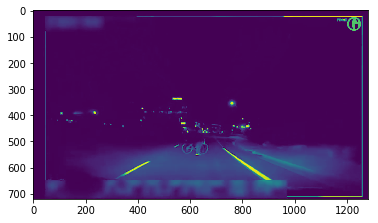

In [7]:
plt.imshow(grayscaled)

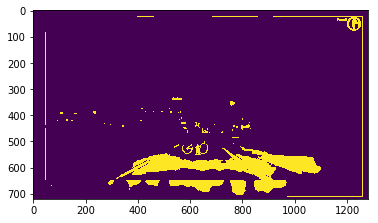

In [8]:
plt.imshow(threshold)

In [9]:
# Follows steps from the paper https://link.springer.com/content/pdf/10.1007%2F11427445_30.pdf
# For size removal: https://stackoverflow.com/questions/42798659/how-to-remove-small-connected-objects-using-opencv

# 1. Make sure size is within range (50, 10000)
# 2. Bottom of image within range (0.3, 0.7)
# 3. Ratio of h/w within range (1, 3)
# 4. Area ratio of region to frame within range (0.5, 0.95)
def cleanup_regions(img):
    orig_h, orig_w = img.shape
    # Remove regions with smaller than 50 or more than 10000 pixels
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    #print (stats)
    sizes = stats[1:, -1]; nb_components = nb_components - 1
    min_size = 50
    max_size = 10000
    
    #your answer image
    img2 = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        left, top, w, h, area = stats[i]
            
        # Bottom of image should be within 0.3 to 0.7 of the frame    
        bottom  = top + h
        area_ratio = area / (w * h)
        ratio = h/w
        if (sizes[i] >= min_size and sizes[i] < max_size 
            and (0.1 * orig_h) <= bottom <= (0.9 * orig_h)
            #and 1 <= ratio < 3
            and area_ratio > 0.5): 
            #and area_ratio < 0.95):
            img2[output == i + 1] = 255
            
        img2[int(orig_h*0.9) :] = 0
        img2[: int(orig_h * 0.1)] = 0
        
    return img2

In [10]:
def adaptive_threshold_cleaned(img):
    grayscaled = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thres = cv2.adaptiveThreshold(grayscaled,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,1.1)
    th3_clean = cleanup_regions(thres)
    return th3_clean

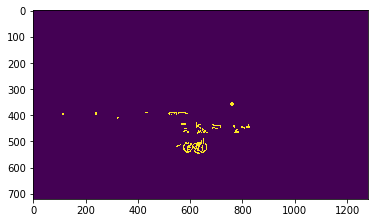

In [14]:
img = cv2.imread('Frames/frame75.jpg')
th3_clean = adaptive_threshold_cleaned(img)
cv2.imwrite("adaptive_thresholding_frame75.jpg", th3_clean)
plt.imshow(th3_clean)

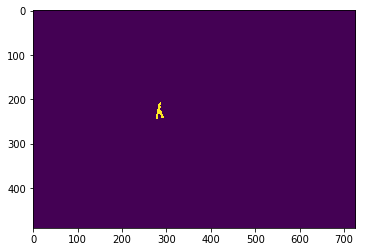

In [15]:
png_img = cv2.imread('test.png')
png_img = adaptive_threshold_cleaned(png_img)
cv2.imwrite("adaptive_thresholding_test_img.jpg", png_img)
plt.imshow(png_img)

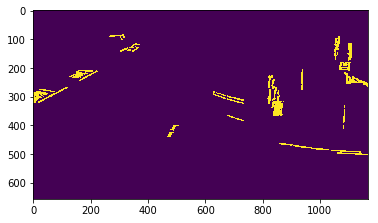

In [168]:
png_img = cv2.imread('night_ped.png')
png_img = cv2.cvtColor(png_img,cv2.COLOR_BGR2RGB)
plt.imshow(adaptive_threshold_cleaned(png_img))

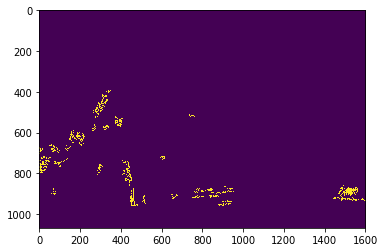

In [169]:
png_img = cv2.imread('night_ped_3.jpg')
plt.imshow(adaptive_threshold_cleaned(png_img))

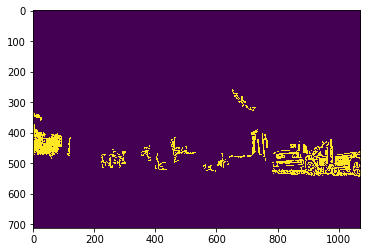

In [170]:
png_img = cv2.imread('night_ped_4.jpg')
plt.imshow(adaptive_threshold_cleaned(png_img))

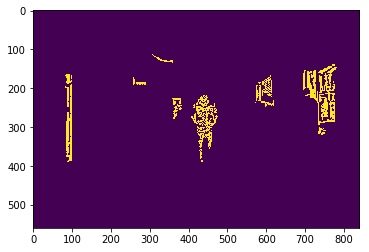

In [171]:
png_img = cv2.imread('night_ped_5.jpg')
plt.imshow(adaptive_threshold_cleaned(png_img))

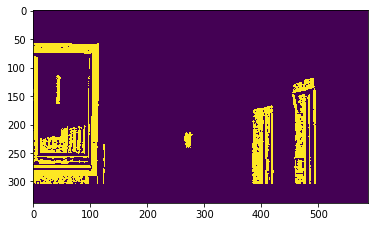

In [172]:
png_img = cv2.imread('night_ped_6.jpeg')
plt.imshow(adaptive_threshold_cleaned(png_img))

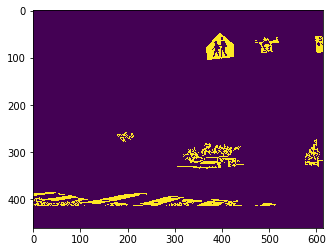

In [173]:
png_img = cv2.imread('night_ped_7.jpg')
plt.imshow(adaptive_threshold_cleaned(png_img))

In [121]:
def awesome_threshold(input_video, outfile, fps=24.4):
    vidcap = cv2.VideoCapture(input_video)
   
    writer = FFmpegWriter(outfile, outputdict={'-r': fps})
    writer = FFmpegWriter(outfile)
    i = 0
    while True:
        ret, image = vidcap.read()
        if not ret: break
        print ("Processing frame #", i)
        i += 1
        writer.writeFrame(adaptive_threshold_cleaned(image))
    writer.close()
    
    
input_video = '/scratch/group/puneet-anjali-group/videos/uber_trimmed.mp4'
outfile = './uber-videos/thres_uber_trimmed.mp4'
awesome_threshold(input_video, outfile)

Processing frame # 0
Processing frame # 1
Processing frame # 2
Processing frame # 3
Processing frame # 4
Processing frame # 5
Processing frame # 6
Processing frame # 7
Processing frame # 8
Processing frame # 9
Processing frame # 10
Processing frame # 11
Processing frame # 12
Processing frame # 13
Processing frame # 14
Processing frame # 15
Processing frame # 16
Processing frame # 17
Processing frame # 18
Processing frame # 19
Processing frame # 20
Processing frame # 21
Processing frame # 22
Processing frame # 23
Processing frame # 24
Processing frame # 25
Processing frame # 26
Processing frame # 27
Processing frame # 28
Processing frame # 29
Processing frame # 30
Processing frame # 31
Processing frame # 32
Processing frame # 33
Processing frame # 34
Processing frame # 35
Processing frame # 36
Processing frame # 37
Processing frame # 38
Processing frame # 39
Processing frame # 40
Processing frame # 41
Processing frame # 42
Processing frame # 43
Processing frame # 44
Processing frame # 4

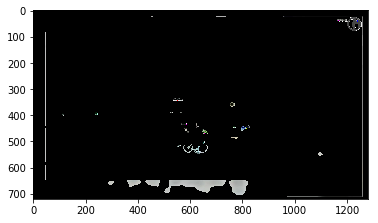

In [47]:
# some structure stuff - no point
img_bw = img2
se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

mask = np.dstack([mask, mask, mask]) / 255
out = img * mask
plt.imshow(out)

## Canny Edge Detector

In [293]:
# Function which finds canny edges of an image
# Upper and lower thresholds based on mean value of equalised histogram of image

def getEdges(img):
    blur = cv2.blur(img,(5,5))
    imgEq = cv2.equalizeHist(blur)
    average = cv2.mean(imgEq)[0]
    topQ = 1.33*average
    lowQ = 0.66*average
    canny = cv2.Canny(imgEq,lowQ , topQ)
    return canny

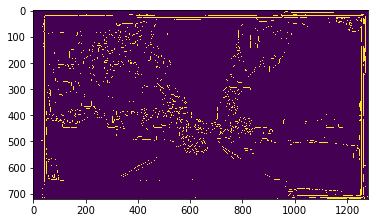

In [300]:
canny_image = getEdges(grayscaled)
plt.imshow(canny_image)

In [91]:
def canny_edge_detector(input_video, outfile, fps=30):
    vidcap = cv2.VideoCapture(input_video)
   
    writer = FFmpegWriter(outfile, outputdict={'-r': fps})
    writer = FFmpegWriter(outfile)
    
    while True:
        ret, image = vidcap.read()
        if not ret: break
        image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        equ = getEdges(image)
        writer.writeFrame(equ)
    writer.close()
    
    
input_video = '/scratch/group/puneet-anjali-group/videos/uber_trimmed.mp4'
outfile = './uber-videos/uber_canny_edge.mp4'
canny_edge_detector(input_video, outfile)

In [95]:
# Function implementing Harris Corner Detection

def harris(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst, None)
    img[dst > 0.01*dst.max()] = [0,0,255]
    return img


# Function which implements openCV's Contrast Limited Adaptive Histogram Equalisation
# Includes convertion from BGR colour space to LAB (luminance channel) colour space
# Stack Overflow help, credit to @ Jeru Luke
def convertIllumination(img):
    
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
 
    #-----Converting image from LAB Color model to RGB model--------------------
    illume = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return illume

# Function to remove the green colours from the images
# This is an example of region of interest extraction methodology
# And a heuristic to speed up processing times


def filterGreenColour(img):
    # Blur the image 
    blur = cv2.GaussianBlur(img, (15,15), 2)
    # Convert to HSV colour space, can isolate Hue channel
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
    # open cv hue is 0-180, sat and value 0-255
    lower_green = np.array([30,70,0])
    upper_green = np.array([80,255,255])
    # Keeps the pixels in the given range
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological opening (erosion follwoed by dilation)
    kernel = np.ones((5,5), np.uint8)
    mask2 = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    res = cv2.bitwise_and(img,img, mask = mask);
    img = img - res
    return img
# Function for automatic detecting and highlighting obstacles that rise above the road surface plane
# HG pedestrian detection
# Credit to lecture course examples.

def hog(img):
    hog = cv2.HOGDescriptor();
    hog.setSVMDetector( cv2.HOGDescriptor_getDefaultPeopleDetector() );
     # perform HOG based pedestrain detection

    found, w = hog.detectMultiScale(img, winStride=(8,8), padding=(32,32), scale=1.05)
    found_filtered = []

    for ri, r in enumerate(found):
        for qi, q in enumerate(found):
            if ri != qi and inside(r, q):
                break
            else:
                found_filtered.append(r)

    draw_detections(img, found)
    draw_detections(img, found_filtered, 3)
    
    return img

# Function to 'crop' image
# Create a 'box' of image, setting pixels outside this box to 0
# This is an example of region of interest extraction methodology
# And a heuristic to speed up processing times
def cropImage(img):
    width, height = img.shape[:2]
    for i in range(0, width):
        for j in range(0, height):
            if i > width*0.8 or i < width*0.2 or j > height*0.8 or j < height*0.2:
                img[i][j] = [255,255,255]
    return img

## Test image

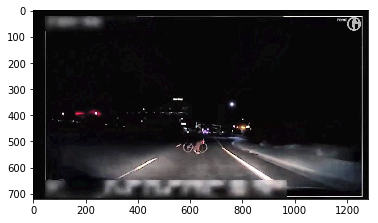

In [94]:
illume = convertIllumination(img);
plt.imshow(illume)

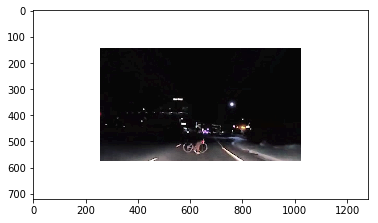

In [99]:
crop = cropImage(illume)
plt.imshow(crop)

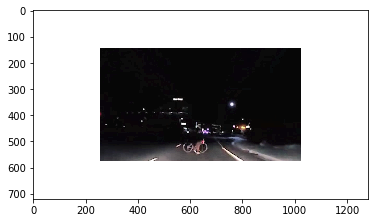

In [100]:
colourCrop = filterGreenColour(crop)
plt.imshow(colourCrop)

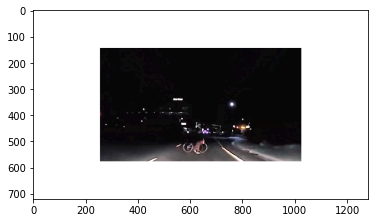

In [101]:
# Gaussian Blur 
illume = cv2.GaussianBlur(colourCrop, (5, 5),0)
plt.imshow(illume)